In [1]:
import torch
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import models.archs.PAN_arch as PAN_arch
import models.archs.SRResNet_arch as SRResNet_arch
import models.archs.RCAN_arch as RCAN_arch
import utils.util as util
from data.util import bgr2ycbcr

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

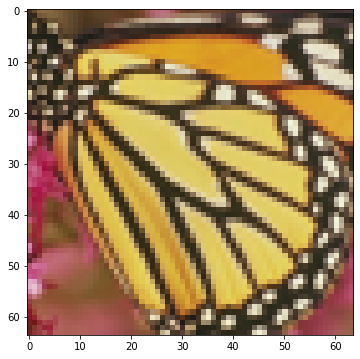

In [10]:
# set5
gt_path = '../datasets/Set5/HR/*.png'
lr_path = '../datasets/Set5/LR_bicubic/X4/*.png'

# Set14
# gt_path = '/mnt/hyzhao/Documents/datasets/benchmark/Set14/HR/*.png'
# lr_path = '/mnt/hyzhao/Documents/datasets/benchmark/Set14/LR_bicubic/X3/*.png'

# B100
# gt_path = '/mnt/hyzhao/Documents/datasets/benchmark/B100/HR/*.png'
# lr_path = '/mnt/hyzhao/Documents/datasets/benchmark/B100/LR_bicubic/X3/*.png'

# Urban100
# gt_path = '/mnt/hyzhao/Documents/datasets/benchmark/Urban100/HR/*.png'
# lr_path = '/mnt/hyzhao/Documents/datasets/benchmark/Urban100/LR_bicubic/X4/*.png'

# # Manga109
# gt_path = '/mnt/hyzhao/Documents/datasets/benchmark/Manga109/HR/*.png'
# lr_path = '/mnt/hyzhao/Documents/datasets/benchmark/Manga109/LR_bicubic/X3/*.png'

# DIV2K 100
# lr_path = '/mnt/hyzhao/Documents/datasets/DIV2K_Valid/LR/X4/*.png'
# gt_path = '/mnt/hyzhao/Documents/datasets/DIV2K_Valid/HR/X4/*.png'

val_lr = sorted(glob.glob(lr_path))
val_gt = sorted(glob.glob(gt_path))
im = cv2.imread(val_lr[2])/255.
# BGR to RGB
im = im[:,:,[2,1,0]]
plt.figure(figsize=(6,6))
plt.imshow(im)

In [11]:
def readimg(path):
    im = cv2.imread(path)
    if im.shape[2] == 1:
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    else:
        im = im.astype(np.float32) / 255.
    im = im[:,:,[2,1,0]]
    return im

def img2tensor(img):
    imgt = torch.from_numpy(np.ascontiguousarray(np.transpose(img, (2, 0, 1)))).float()[None, ...]
    return imgt

def modcrop(img_in, scale):
    """img_in: Numpy, HWC or HW"""
    img = np.copy(img_in)
    if img.ndim == 2:
        H, W = img.shape
        H_r, W_r = H % scale, W % scale
        img = img[:H - H_r, :W - W_r]
    elif img.ndim == 3:
        H, W, C = img.shape
        H_r, W_r = H % scale, W % scale
        img = img[:H - H_r, :W - W_r, :]
    else:
        raise ValueError('Wrong img ndim: [{:d}].'.format(img.ndim))
    return img

In [12]:
model = PAN_arch.PAN(in_nc=3, out_nc=3, nf=40, unf=24, nb=16, scale=4)
model_weight = torch.load('../experiments/pretrained_models/PANx4_DF2K.pth')
model.load_state_dict(model_weight)
model.cuda()
model.eval()

PAN(
  (conv_first): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (SCPA_trunk): Sequential(
    (0): SCPA(
      (conv1_a): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv1_b): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (k1): Sequential(
        (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (PAConv): PAConv(
        (k2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
        (sigmoid): Sigmoid()
        (k3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (k4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): SCPA(
      (conv1_a): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv1_b): Conv2d(40, 20, kernel_size=(

In [13]:
scale = 4
psnrs = []
ssims = []
for i in range(len(val_lr)):
    im = readimg(val_lr[i])
    gt_img = readimg(val_gt[i])
    gt_img = modcrop(gt_img, scale)
    imgt = img2tensor(im)
    gt_img = img2tensor(gt_img)
#     out_ = util.flipx4_forward(model, imgt.cuda())
#     out_ = util.flipxrot_forward(model, imgt.cuda())
    out_ = util.single_forward(model, imgt.cuda())
    sr_img = util.tensor2img(out_)
    gt_img = util.tensor2img(gt_img)
    
    # caculate the PSNR
    sr_img, gt_img = util.crop_border([sr_img, gt_img], scale)
    psnr = util.calculate_psnr(sr_img, gt_img)
    sr_img_y = bgr2ycbcr(sr_img / 255., only_y=True)
    gt_img_y = bgr2ycbcr(gt_img / 255., only_y=True)
    psnr_y = util.calculate_psnr(sr_img_y * 255, gt_img_y * 255)
    ssim_y = util.calculate_ssim(sr_img_y * 255, gt_img_y * 255)
    psnrs.append(psnr_y)
    ssims.append(ssim_y)
    print(i+1, psnr_y, ssim_y)

1 30.787876880162138 0.871325388656959
2 31.579571953392932 0.9220292458219951
3 24.972292377947344 0.873762738972855
4 31.924400665548664 0.7869982638048361
5 27.618549674036483 0.883720286462827


## ensemble

In [14]:
scale = 4
psnrs = []
ssims = []
for i in range(len(val_lr)):
    im = readimg(val_lr[i])
    gt_img = readimg(val_gt[i])
    gt_img = modcrop(gt_img, scale)
    imgt = img2tensor(im)
    gt_img = img2tensor(gt_img)
    out_ = util.flipx4_forward(model, imgt.cuda())
    sr_img = util.tensor2img(out_)
    gt_img = util.tensor2img(gt_img)
    
    # caculate the PSNR
    sr_img, gt_img = util.crop_border([sr_img, gt_img], scale)
    psnr = util.calculate_psnr(sr_img, gt_img)
    sr_img_y = bgr2ycbcr(sr_img / 255., only_y=True)
    gt_img_y = bgr2ycbcr(gt_img / 255., only_y=True)
    psnr_y = util.calculate_psnr(sr_img_y * 255, gt_img_y * 255)
    ssim_y = util.calculate_ssim(sr_img_y * 255, gt_img_y * 255)
    psnrs.append(psnr_y)
    ssims.append(ssim_y)
    print(i+1, psnr_y, ssim_y)

1 30.80493779300941 0.87180777060493
2 31.613496521254987 0.9227291687804005
3 25.068768612766252 0.8762356914918216
4 31.952953973448214 0.7877473101649023
5 27.64189371319659 0.8840079311545765
